In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda:1


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 1])

In [33]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 1])

In [34]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [37]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'No_norm_model'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.4137482  Validation_loss:  0.35599953  Test_loss:  0.4077833


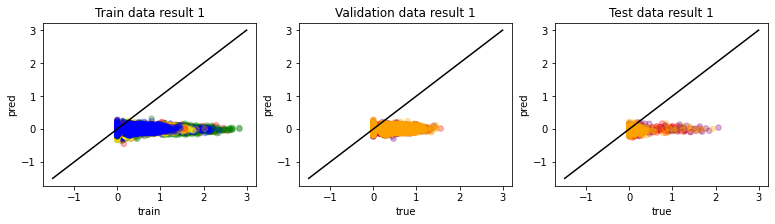

Epoch  100 Train_loss:  0.2421627  Validation_loss:  0.23379788  Test_loss:  0.22930452
Epoch  200 Train_loss:  0.23611411  Validation_loss:  0.2291392  Test_loss:  0.22264148
Epoch  300 Train_loss:  0.23187006  Validation_loss:  0.22568548  Test_loss:  0.21823172
Epoch  400 Train_loss:  0.22864826  Validation_loss:  0.22299758  Test_loss:  0.21485214
Epoch  500 Train_loss:  0.2260453  Validation_loss:  0.22082081  Test_loss:  0.21211228
Epoch  600 Train_loss:  0.22388381  Validation_loss:  0.21905513  Test_loss:  0.20976518
Epoch  700 Train_loss:  0.22202684  Validation_loss:  0.21754384  Test_loss:  0.20775369
Epoch  800 Train_loss:  0.220411  Validation_loss:  0.21633245  Test_loss:  0.20593004
Epoch  900 Train_loss:  0.21896623  Validation_loss:  0.2151851  Test_loss:  0.2042756
Epoch  1000 Train_loss:  0.21766976  Validation_loss:  0.21420838  Test_loss:  0.2027794


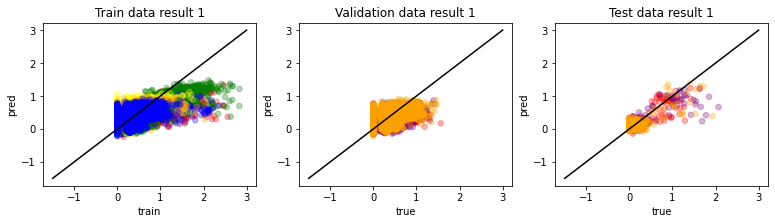

Epoch  1100 Train_loss:  0.21649505  Validation_loss:  0.21332814  Test_loss:  0.20144293
Epoch  1200 Train_loss:  0.21542335  Validation_loss:  0.21250422  Test_loss:  0.20023245
Epoch  1300 Train_loss:  0.21443151  Validation_loss:  0.21173668  Test_loss:  0.19914232
Epoch  1400 Train_loss:  0.213514  Validation_loss:  0.21106566  Test_loss:  0.19810759
Epoch  1500 Train_loss:  0.21265563  Validation_loss:  0.2104176  Test_loss:  0.19717532
Epoch  1600 Train_loss:  0.21184924  Validation_loss:  0.20981437  Test_loss:  0.19632581
Epoch  1700 Train_loss:  0.21108925  Validation_loss:  0.209288  Test_loss:  0.19549009
Epoch  1800 Train_loss:  0.21037616  Validation_loss:  0.20874985  Test_loss:  0.19470993
Epoch  1900 Train_loss:  0.20970026  Validation_loss:  0.20826997  Test_loss:  0.19400157
Epoch  2000 Train_loss:  0.20906241  Validation_loss:  0.2078128  Test_loss:  0.19332848


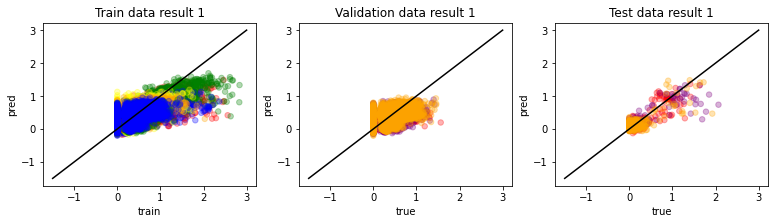

Epoch  2100 Train_loss:  0.20845844  Validation_loss:  0.20733485  Test_loss:  0.19271316
Epoch  2200 Train_loss:  0.2078801  Validation_loss:  0.20694791  Test_loss:  0.19210516
Epoch  2300 Train_loss:  0.20733085  Validation_loss:  0.20650901  Test_loss:  0.19157194
Epoch  2400 Train_loss:  0.206804  Validation_loss:  0.20612982  Test_loss:  0.19103932
Epoch  2500 Train_loss:  0.206299  Validation_loss:  0.20575142  Test_loss:  0.1905729
Epoch  2600 Train_loss:  0.20581505  Validation_loss:  0.20540632  Test_loss:  0.19006455
Epoch  2700 Train_loss:  0.20534903  Validation_loss:  0.20505576  Test_loss:  0.1896308
Epoch  2800 Train_loss:  0.2049012  Validation_loss:  0.20471403  Test_loss:  0.18919717
Epoch  2900 Train_loss:  0.20446917  Validation_loss:  0.2043838  Test_loss:  0.18881184
Epoch  3000 Train_loss:  0.20405002  Validation_loss:  0.20406628  Test_loss:  0.18841146


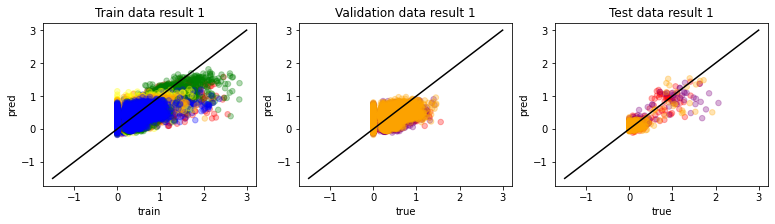

Epoch  3100 Train_loss:  0.20364672  Validation_loss:  0.20375265  Test_loss:  0.18806091
Epoch  3200 Train_loss:  0.2032558  Validation_loss:  0.20345744  Test_loss:  0.18768257
Epoch  3300 Train_loss:  0.20287617  Validation_loss:  0.20316048  Test_loss:  0.18735106
Epoch  3400 Train_loss:  0.20250559  Validation_loss:  0.20288628  Test_loss:  0.18704285
Epoch  3500 Train_loss:  0.20214613  Validation_loss:  0.20260437  Test_loss:  0.18670404
Epoch  3600 Train_loss:  0.20179702  Validation_loss:  0.20233016  Test_loss:  0.186386
Epoch  3700 Train_loss:  0.20145862  Validation_loss:  0.20206003  Test_loss:  0.18611743
Epoch  3800 Train_loss:  0.20112714  Validation_loss:  0.20181015  Test_loss:  0.18583064
Epoch  3900 Train_loss:  0.20080312  Validation_loss:  0.2015502  Test_loss:  0.18552643
Epoch  4000 Train_loss:  0.20048726  Validation_loss:  0.20129962  Test_loss:  0.18526278


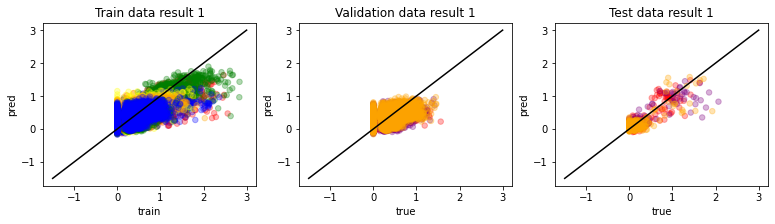

Epoch  4100 Train_loss:  0.20018046  Validation_loss:  0.2010451  Test_loss:  0.18500029
Epoch  4200 Train_loss:  0.19987951  Validation_loss:  0.20081307  Test_loss:  0.1847711
Epoch  4300 Train_loss:  0.19958484  Validation_loss:  0.20057337  Test_loss:  0.18453313
Epoch  4400 Train_loss:  0.1992956  Validation_loss:  0.20034301  Test_loss:  0.18427289
Epoch  4500 Train_loss:  0.19901167  Validation_loss:  0.2001256  Test_loss:  0.1840596
Epoch  4600 Train_loss:  0.19873516  Validation_loss:  0.1998928  Test_loss:  0.1838319
Epoch  4700 Train_loss:  0.19846201  Validation_loss:  0.19967625  Test_loss:  0.18361948
Epoch  4800 Train_loss:  0.1981942  Validation_loss:  0.19946538  Test_loss:  0.18341812
Epoch  4900 Train_loss:  0.1979306  Validation_loss:  0.19925602  Test_loss:  0.18322636
Epoch  5000 Train_loss:  0.19767196  Validation_loss:  0.19904129  Test_loss:  0.18301405


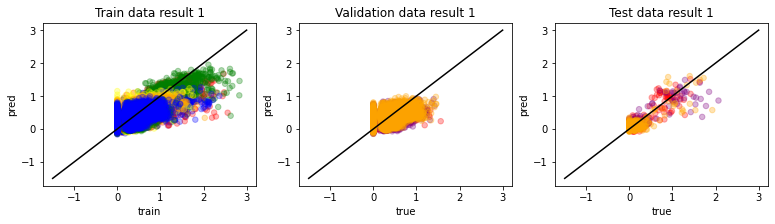

Epoch  5100 Train_loss:  0.1974183  Validation_loss:  0.1988318  Test_loss:  0.1828291
Epoch  5200 Train_loss:  0.19716659  Validation_loss:  0.19863318  Test_loss:  0.18266916
Epoch  5300 Train_loss:  0.19692147  Validation_loss:  0.19842798  Test_loss:  0.18247049
Epoch  5400 Train_loss:  0.19667889  Validation_loss:  0.19823478  Test_loss:  0.18229394
Epoch  5500 Train_loss:  0.19644251  Validation_loss:  0.19805387  Test_loss:  0.18209437
Epoch  5600 Train_loss:  0.19620621  Validation_loss:  0.19785254  Test_loss:  0.18196885
Epoch  5700 Train_loss:  0.19597566  Validation_loss:  0.19765696  Test_loss:  0.18179211
Epoch  5800 Train_loss:  0.19574729  Validation_loss:  0.19746141  Test_loss:  0.18161526
Epoch  5900 Train_loss:  0.19552082  Validation_loss:  0.19728602  Test_loss:  0.18145959
Epoch  6000 Train_loss:  0.19529948  Validation_loss:  0.19709405  Test_loss:  0.18133605


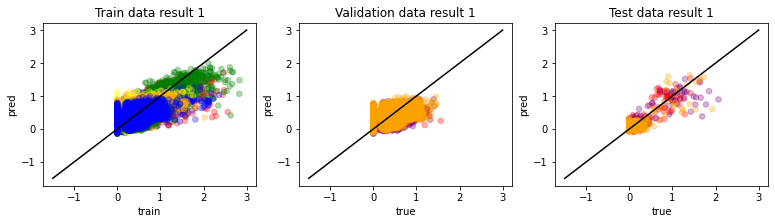

Epoch  6100 Train_loss:  0.19507906  Validation_loss:  0.19691738  Test_loss:  0.18119608
Epoch  6200 Train_loss:  0.19486225  Validation_loss:  0.19673398  Test_loss:  0.18104173
Epoch  6300 Train_loss:  0.19464833  Validation_loss:  0.19655804  Test_loss:  0.18089546
Epoch  6400 Train_loss:  0.19443445  Validation_loss:  0.19638605  Test_loss:  0.18076244
Epoch  6500 Train_loss:  0.1942245  Validation_loss:  0.19621165  Test_loss:  0.18060623
Epoch  6600 Train_loss:  0.19401866  Validation_loss:  0.19602829  Test_loss:  0.18045469
Epoch  6700 Train_loss:  0.19381316  Validation_loss:  0.19585466  Test_loss:  0.18032451
Epoch  6800 Train_loss:  0.1936094  Validation_loss:  0.19569013  Test_loss:  0.1802158
Epoch  6900 Train_loss:  0.19340687  Validation_loss:  0.1955267  Test_loss:  0.18008944
Epoch  7000 Train_loss:  0.19320865  Validation_loss:  0.19534904  Test_loss:  0.17993984


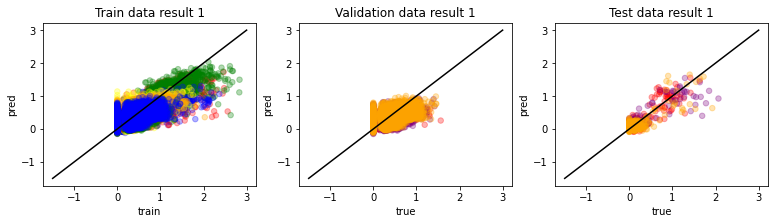

Epoch  7100 Train_loss:  0.19301067  Validation_loss:  0.19518341  Test_loss:  0.1798202
Epoch  7200 Train_loss:  0.19281377  Validation_loss:  0.19502896  Test_loss:  0.17970107
Epoch  7300 Train_loss:  0.19262035  Validation_loss:  0.19486275  Test_loss:  0.17959207
Epoch  7400 Train_loss:  0.19243017  Validation_loss:  0.19469312  Test_loss:  0.17950146
Epoch  7500 Train_loss:  0.19223793  Validation_loss:  0.1945308  Test_loss:  0.17938307
Epoch  7600 Train_loss:  0.19204833  Validation_loss:  0.1943724  Test_loss:  0.17930016
Epoch  7700 Train_loss:  0.19185974  Validation_loss:  0.19421783  Test_loss:  0.17920305
Epoch  7800 Train_loss:  0.19167246  Validation_loss:  0.19406286  Test_loss:  0.17911085
Epoch  7900 Train_loss:  0.19148783  Validation_loss:  0.19390541  Test_loss:  0.17897965
Epoch  8000 Train_loss:  0.19130337  Validation_loss:  0.1937549  Test_loss:  0.17886543


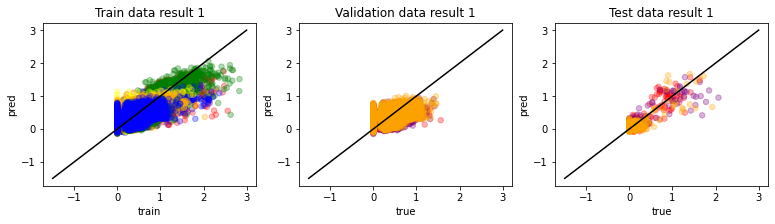

Epoch  8100 Train_loss:  0.19112019  Validation_loss:  0.19359772  Test_loss:  0.17879437
Epoch  8200 Train_loss:  0.19093946  Validation_loss:  0.19344206  Test_loss:  0.17866363
Epoch  8300 Train_loss:  0.19075908  Validation_loss:  0.19329207  Test_loss:  0.17855799
Epoch  8400 Train_loss:  0.19057992  Validation_loss:  0.19313844  Test_loss:  0.17847334
Epoch  8500 Train_loss:  0.19040203  Validation_loss:  0.19299024  Test_loss:  0.17838308
Epoch  8600 Train_loss:  0.19022462  Validation_loss:  0.1928421  Test_loss:  0.1782963
Epoch  8700 Train_loss:  0.19004875  Validation_loss:  0.19268924  Test_loss:  0.17823088
Epoch  8800 Train_loss:  0.18987425  Validation_loss:  0.19254272  Test_loss:  0.17811835
Epoch  8900 Train_loss:  0.18970013  Validation_loss:  0.19239818  Test_loss:  0.17805457
Epoch  9000 Train_loss:  0.18952863  Validation_loss:  0.19224395  Test_loss:  0.17795643


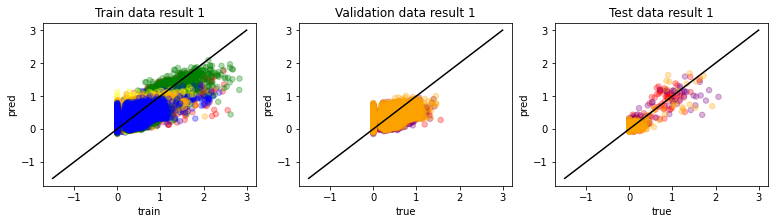

Epoch  9100 Train_loss:  0.18935555  Validation_loss:  0.19209464  Test_loss:  0.17787725
Epoch  9200 Train_loss:  0.18918493  Validation_loss:  0.19194916  Test_loss:  0.17780566
Epoch  9300 Train_loss:  0.18901438  Validation_loss:  0.19181226  Test_loss:  0.17774118
Epoch  9400 Train_loss:  0.18884678  Validation_loss:  0.19165684  Test_loss:  0.1776529
Epoch  9500 Train_loss:  0.18867908  Validation_loss:  0.19152047  Test_loss:  0.17759383
Epoch  9600 Train_loss:  0.18850979  Validation_loss:  0.19138637  Test_loss:  0.17752329
Epoch  9700 Train_loss:  0.1883439  Validation_loss:  0.19124034  Test_loss:  0.17743035
Epoch  9800 Train_loss:  0.188178  Validation_loss:  0.19109844  Test_loss:  0.17735894
Epoch  9900 Train_loss:  0.18801169  Validation_loss:  0.1909652  Test_loss:  0.17730151
Epoch  10000 Train_loss:  0.18784735  Validation_loss:  0.19082388  Test_loss:  0.17723712


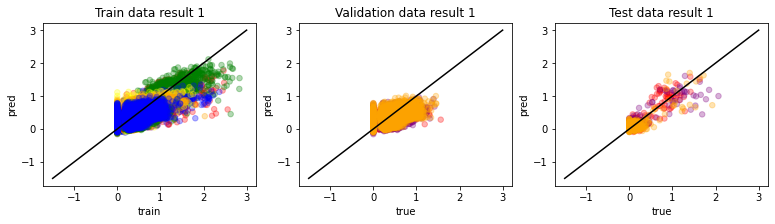

Epoch  10100 Train_loss:  0.18768401  Validation_loss:  0.19068047  Test_loss:  0.1771512
Epoch  10200 Train_loss:  0.18752237  Validation_loss:  0.19053642  Test_loss:  0.1770894
Epoch  10300 Train_loss:  0.18735941  Validation_loss:  0.19039916  Test_loss:  0.17703728
Epoch  10400 Train_loss:  0.18719798  Validation_loss:  0.1902612  Test_loss:  0.1769823
Epoch  10500 Train_loss:  0.18703596  Validation_loss:  0.19012655  Test_loss:  0.17692828
Epoch  10600 Train_loss:  0.18687586  Validation_loss:  0.18998724  Test_loss:  0.17688036
Epoch  10700 Train_loss:  0.18671574  Validation_loss:  0.18984763  Test_loss:  0.17681836
Epoch  10800 Train_loss:  0.18655574  Validation_loss:  0.1897143  Test_loss:  0.1767765
Epoch  10900 Train_loss:  0.18639633  Validation_loss:  0.18958226  Test_loss:  0.17672679
Epoch  11000 Train_loss:  0.18623899  Validation_loss:  0.18944077  Test_loss:  0.17665799


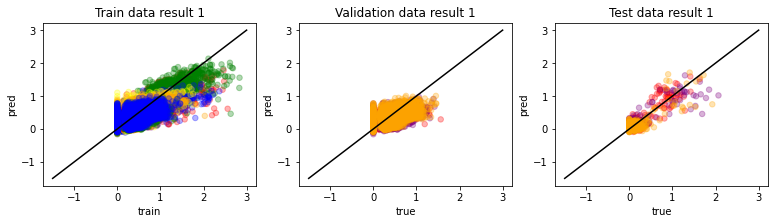

Epoch  11100 Train_loss:  0.18608066  Validation_loss:  0.18930526  Test_loss:  0.17660135
Epoch  11200 Train_loss:  0.18592422  Validation_loss:  0.18916674  Test_loss:  0.17654751
Epoch  11300 Train_loss:  0.1857668  Validation_loss:  0.18903607  Test_loss:  0.17651255
Epoch  11400 Train_loss:  0.18561092  Validation_loss:  0.18889739  Test_loss:  0.17644031
Epoch  11500 Train_loss:  0.18545404  Validation_loss:  0.18877228  Test_loss:  0.17642015
Epoch  11600 Train_loss:  0.18529777  Validation_loss:  0.18863943  Test_loss:  0.1763775
Epoch  11700 Train_loss:  0.1851437  Validation_loss:  0.1885009  Test_loss:  0.1763139
Epoch  11800 Train_loss:  0.18498833  Validation_loss:  0.18836984  Test_loss:  0.17626595
Epoch  11900 Train_loss:  0.18483357  Validation_loss:  0.18823956  Test_loss:  0.17623645
Epoch  12000 Train_loss:  0.18467951  Validation_loss:  0.1881087  Test_loss:  0.17619719


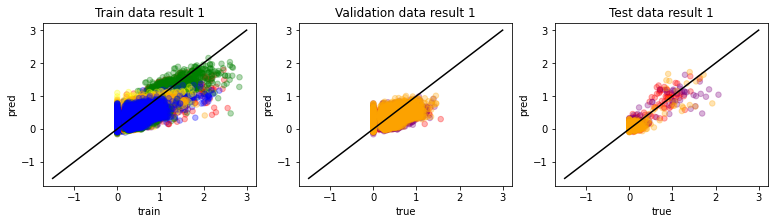

Epoch  12100 Train_loss:  0.18452601  Validation_loss:  0.18797575  Test_loss:  0.17614606
Epoch  12200 Train_loss:  0.18437245  Validation_loss:  0.18783982  Test_loss:  0.17610273
Epoch  12300 Train_loss:  0.18421881  Validation_loss:  0.18771365  Test_loss:  0.1760792
Epoch  12400 Train_loss:  0.1840668  Validation_loss:  0.18758236  Test_loss:  0.17604807
Epoch  12500 Train_loss:  0.18391475  Validation_loss:  0.18744972  Test_loss:  0.17600554
Epoch  12600 Train_loss:  0.18376161  Validation_loss:  0.18732311  Test_loss:  0.17599477
Epoch  12700 Train_loss:  0.1836117  Validation_loss:  0.1871868  Test_loss:  0.17594123
Epoch  12800 Train_loss:  0.18346098  Validation_loss:  0.18705511  Test_loss:  0.17590573
Epoch  12900 Train_loss:  0.1833097  Validation_loss:  0.18692823  Test_loss:  0.1758759
Epoch  13000 Train_loss:  0.18315944  Validation_loss:  0.18679607  Test_loss:  0.17584066


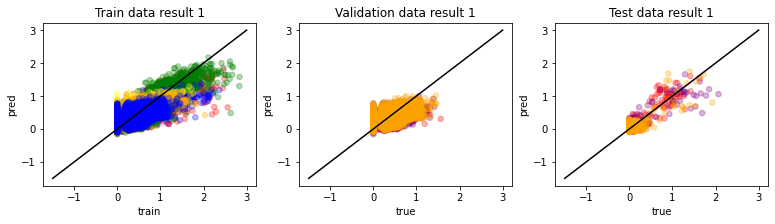

Epoch  13100 Train_loss:  0.18300772  Validation_loss:  0.18667343  Test_loss:  0.17583798
Epoch  13200 Train_loss:  0.18285811  Validation_loss:  0.18653725  Test_loss:  0.17579395
Epoch  13300 Train_loss:  0.18270898  Validation_loss:  0.1864103  Test_loss:  0.17576922
Epoch  13400 Train_loss:  0.18255827  Validation_loss:  0.18628587  Test_loss:  0.1757585
Epoch  13500 Train_loss:  0.18240838  Validation_loss:  0.18615542  Test_loss:  0.17573208
Epoch  13600 Train_loss:  0.18226121  Validation_loss:  0.18602121  Test_loss:  0.17567585
Epoch  13700 Train_loss:  0.18211395  Validation_loss:  0.18589175  Test_loss:  0.17563906
Epoch  13800 Train_loss:  0.1819656  Validation_loss:  0.18576176  Test_loss:  0.17562374
Epoch  13900 Train_loss:  0.18181595  Validation_loss:  0.18563607  Test_loss:  0.17561524
Epoch  14000 Train_loss:  0.1816676  Validation_loss:  0.18551241  Test_loss:  0.17561388


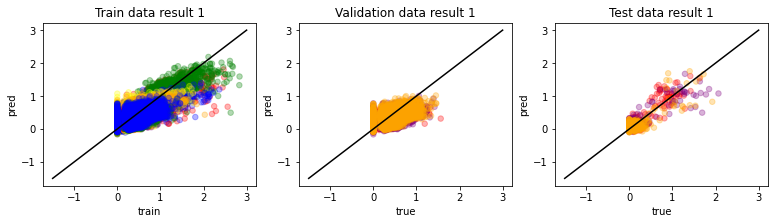

Epoch  14100 Train_loss:  0.18152003  Validation_loss:  0.18538313  Test_loss:  0.17559116
Epoch  14200 Train_loss:  0.18137161  Validation_loss:  0.18525578  Test_loss:  0.17557667
Epoch  14300 Train_loss:  0.1812249  Validation_loss:  0.18512337  Test_loss:  0.17553827
Epoch  14400 Train_loss:  0.18107638  Validation_loss:  0.18500368  Test_loss:  0.17555642
Epoch  14500 Train_loss:  0.18093008  Validation_loss:  0.18487318  Test_loss:  0.175532
Epoch  14600 Train_loss:  0.18078393  Validation_loss:  0.18474767  Test_loss:  0.175506
Epoch  14700 Train_loss:  0.18063663  Validation_loss:  0.18461768  Test_loss:  0.17549126
Epoch  14800 Train_loss:  0.18048957  Validation_loss:  0.18449196  Test_loss:  0.17548665
Epoch  14900 Train_loss:  0.18034208  Validation_loss:  0.18436685  Test_loss:  0.17547728
Epoch  15000 Train_loss:  0.18019569  Validation_loss:  0.18423592  Test_loss:  0.17545651


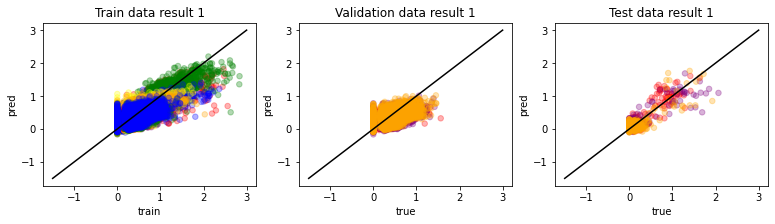

Epoch  15100 Train_loss:  0.18004917  Validation_loss:  0.18411504  Test_loss:  0.17545734
Epoch  15200 Train_loss:  0.17990425  Validation_loss:  0.18398303  Test_loss:  0.17544253
Epoch  15300 Train_loss:  0.1797573  Validation_loss:  0.18385291  Test_loss:  0.17543578
Epoch  15400 Train_loss:  0.17961018  Validation_loss:  0.18373272  Test_loss:  0.17545523
Epoch  15500 Train_loss:  0.17946503  Validation_loss:  0.18360254  Test_loss:  0.17543422
Epoch  15600 Train_loss:  0.17931877  Validation_loss:  0.1834769  Test_loss:  0.17543061
Epoch  15700 Train_loss:  0.17917348  Validation_loss:  0.18334918  Test_loss:  0.1754167
Epoch  15800 Train_loss:  0.17902882  Validation_loss:  0.18322146  Test_loss:  0.175403
Epoch  15900 Train_loss:  0.17888245  Validation_loss:  0.18309684  Test_loss:  0.17539938
Epoch  16000 Train_loss:  0.17873533  Validation_loss:  0.18297373  Test_loss:  0.17541659


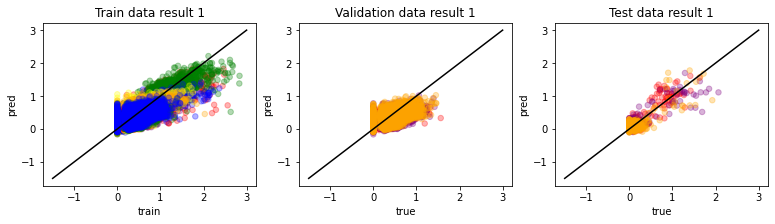

Epoch  16100 Train_loss:  0.17859015  Validation_loss:  0.1828429  Test_loss:  0.17539711
Epoch  16200 Train_loss:  0.17844553  Validation_loss:  0.18271668  Test_loss:  0.17539777
Epoch  16300 Train_loss:  0.17829925  Validation_loss:  0.18259363  Test_loss:  0.17541201
Epoch  16400 Train_loss:  0.17815451  Validation_loss:  0.182465  Test_loss:  0.17539966
Epoch  16500 Train_loss:  0.1780096  Validation_loss:  0.18233745  Test_loss:  0.17539626
Epoch  16600 Train_loss:  0.17786361  Validation_loss:  0.18221174  Test_loss:  0.17540544
Epoch  16700 Train_loss:  0.17771864  Validation_loss:  0.1820846  Test_loss:  0.17540006
Epoch  16800 Train_loss:  0.17757389  Validation_loss:  0.18195216  Test_loss:  0.1753883
Epoch  16900 Train_loss:  0.1774273  Validation_loss:  0.18182902  Test_loss:  0.17541371
Epoch  17000 Train_loss:  0.17728259  Validation_loss:  0.18170013  Test_loss:  0.17541125


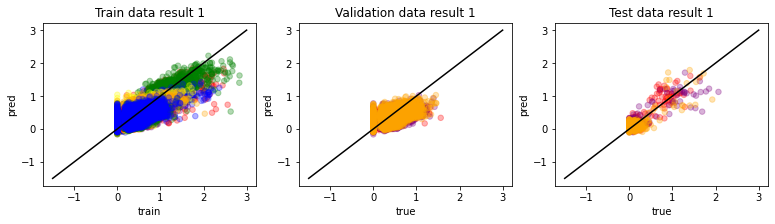

Epoch  17100 Train_loss:  0.17713651  Validation_loss:  0.18157382  Test_loss:  0.1754372
Epoch  17200 Train_loss:  0.17699344  Validation_loss:  0.18144384  Test_loss:  0.17540899
Epoch  17300 Train_loss:  0.17684813  Validation_loss:  0.18131767  Test_loss:  0.17543504
Epoch  17400 Train_loss:  0.17670283  Validation_loss:  0.1811891  Test_loss:  0.17545092
Epoch  17500 Train_loss:  0.17655869  Validation_loss:  0.1810601  Test_loss:  0.17543636
Epoch  17600 Train_loss:  0.1764139  Validation_loss:  0.18093227  Test_loss:  0.17545299
Epoch  17700 Train_loss:  0.17626809  Validation_loss:  0.18080351  Test_loss:  0.17547533
Epoch  17800 Train_loss:  0.1761238  Validation_loss:  0.18067797  Test_loss:  0.17547601
Epoch  17900 Train_loss:  0.17597757  Validation_loss:  0.18055893  Test_loss:  0.17551951
Epoch  18000 Train_loss:  0.17583504  Validation_loss:  0.18042317  Test_loss:  0.17549707


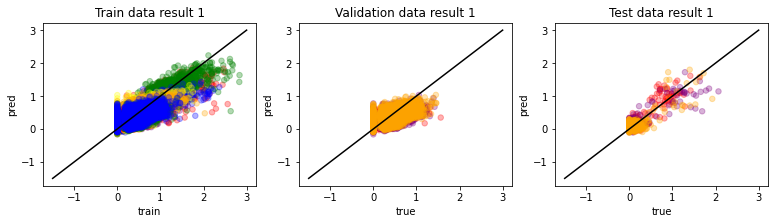

Epoch  18100 Train_loss:  0.17569014  Validation_loss:  0.18029632  Test_loss:  0.17550078
Epoch  18200 Train_loss:  0.17554575  Validation_loss:  0.18016921  Test_loss:  0.17551863
Epoch  18300 Train_loss:  0.17540053  Validation_loss:  0.18004747  Test_loss:  0.17555168
Epoch  18400 Train_loss:  0.17525628  Validation_loss:  0.17991799  Test_loss:  0.17556831
Epoch  18500 Train_loss:  0.17511074  Validation_loss:  0.17979072  Test_loss:  0.17559718
Epoch  18600 Train_loss:  0.17496867  Validation_loss:  0.17965767  Test_loss:  0.17558971
Epoch  18700 Train_loss:  0.17482266  Validation_loss:  0.1795338  Test_loss:  0.17563191
Epoch  18800 Train_loss:  0.17467803  Validation_loss:  0.1794093  Test_loss:  0.17567322
Epoch  18900 Train_loss:  0.17453475  Validation_loss:  0.1792787  Test_loss:  0.17566913
Epoch  19000 Train_loss:  0.17439193  Validation_loss:  0.17914666  Test_loss:  0.17568715


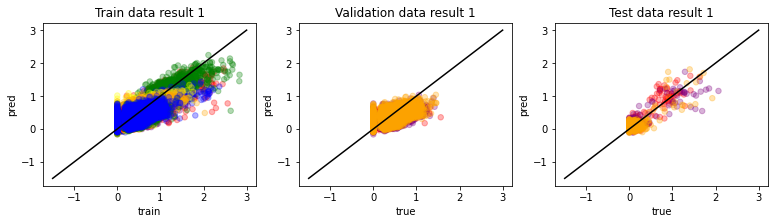

Epoch  19100 Train_loss:  0.1742459  Validation_loss:  0.17902562  Test_loss:  0.17574196
Epoch  19200 Train_loss:  0.17410228  Validation_loss:  0.178898  Test_loss:  0.17575796
Epoch  19300 Train_loss:  0.17395718  Validation_loss:  0.17876725  Test_loss:  0.17576787
Epoch  19400 Train_loss:  0.1738134  Validation_loss:  0.1786377  Test_loss:  0.17579108
Epoch  19500 Train_loss:  0.17366946  Validation_loss:  0.17850584  Test_loss:  0.17579234
Epoch  19600 Train_loss:  0.17352577  Validation_loss:  0.17837815  Test_loss:  0.17579982
Epoch  19700 Train_loss:  0.17337853  Validation_loss:  0.17825755  Test_loss:  0.17587535
Epoch  19800 Train_loss:  0.1732344  Validation_loss:  0.17812568  Test_loss:  0.17589669
Epoch  19900 Train_loss:  0.17309064  Validation_loss:  0.17799632  Test_loss:  0.17590347
Epoch  20000 Train_loss:  0.17294577  Validation_loss:  0.17786658  Test_loss:  0.17592826


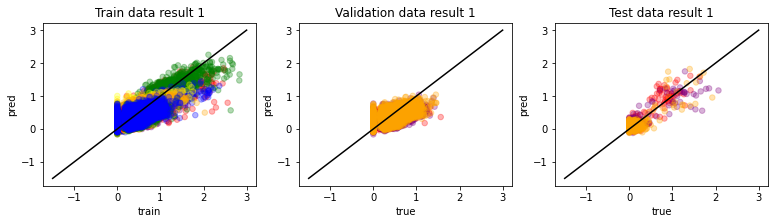

Epoch  20100 Train_loss:  0.17280048  Validation_loss:  0.17774136  Test_loss:  0.17597273
Epoch  20200 Train_loss:  0.17265809  Validation_loss:  0.17760822  Test_loss:  0.17595999
Epoch  20300 Train_loss:  0.17251186  Validation_loss:  0.17748436  Test_loss:  0.17600235
Epoch  20400 Train_loss:  0.17236796  Validation_loss:  0.177351  Test_loss:  0.17600325
Epoch  20500 Train_loss:  0.17222475  Validation_loss:  0.17722103  Test_loss:  0.17602581
Epoch  20600 Train_loss:  0.17207904  Validation_loss:  0.17709272  Test_loss:  0.1760792
Epoch  20700 Train_loss:  0.17193353  Validation_loss:  0.17696589  Test_loss:  0.17612159
Epoch  20800 Train_loss:  0.17179045  Validation_loss:  0.17682952  Test_loss:  0.17610689
Epoch  20900 Train_loss:  0.17164394  Validation_loss:  0.17670286  Test_loss:  0.17617308
Epoch  21000 Train_loss:  0.17149891  Validation_loss:  0.17657334  Test_loss:  0.17620708


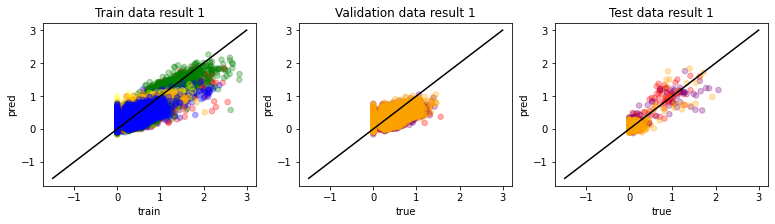

Epoch  21100 Train_loss:  0.17135374  Validation_loss:  0.17644429  Test_loss:  0.17623012
Epoch  21200 Train_loss:  0.17120902  Validation_loss:  0.17631531  Test_loss:  0.1762632
Epoch  21300 Train_loss:  0.17106405  Validation_loss:  0.176184  Test_loss:  0.17630933
Epoch  21400 Train_loss:  0.17092079  Validation_loss:  0.17605321  Test_loss:  0.17632118
Epoch  21500 Train_loss:  0.17077503  Validation_loss:  0.17592402  Test_loss:  0.17635365
Epoch  21600 Train_loss:  0.1706284  Validation_loss:  0.17579769  Test_loss:  0.17640394
Epoch  21700 Train_loss:  0.17048392  Validation_loss:  0.1756642  Test_loss:  0.17641568
Epoch  21800 Train_loss:  0.17033851  Validation_loss:  0.17553632  Test_loss:  0.17646578
Epoch  21900 Train_loss:  0.17019387  Validation_loss:  0.17540598  Test_loss:  0.1764924
Epoch  22000 Train_loss:  0.17004837  Validation_loss:  0.1752738  Test_loss:  0.17652406


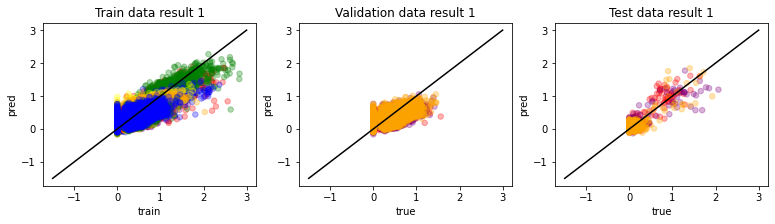

Epoch  22100 Train_loss:  0.16990432  Validation_loss:  0.17513846  Test_loss:  0.17653543
Epoch  22200 Train_loss:  0.16975924  Validation_loss:  0.17500792  Test_loss:  0.17655797
Epoch  22300 Train_loss:  0.1696131  Validation_loss:  0.1748777  Test_loss:  0.17661485
Epoch  22400 Train_loss:  0.16946687  Validation_loss:  0.17475204  Test_loss:  0.17667425
Epoch  22500 Train_loss:  0.16932194  Validation_loss:  0.1746223  Test_loss:  0.17670827
Epoch  22600 Train_loss:  0.16917704  Validation_loss:  0.17448933  Test_loss:  0.17672363
Epoch  22700 Train_loss:  0.16903073  Validation_loss:  0.17435703  Test_loss:  0.17677234
Epoch  22800 Train_loss:  0.16888453  Validation_loss:  0.17422682  Test_loss:  0.17682147
Epoch  22900 Train_loss:  0.16873875  Validation_loss:  0.17409593  Test_loss:  0.17686266
Epoch  23000 Train_loss:  0.16859347  Validation_loss:  0.17396176  Test_loss:  0.17689437


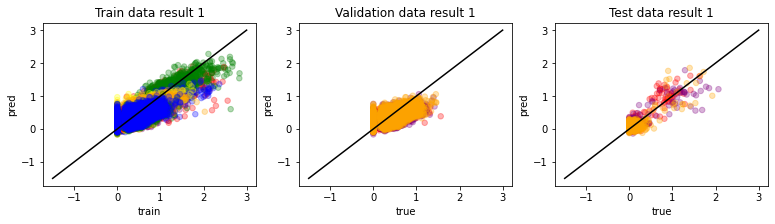

Epoch  23100 Train_loss:  0.16844782  Validation_loss:  0.1738286  Test_loss:  0.17693235
Epoch  23200 Train_loss:  0.16830131  Validation_loss:  0.17370039  Test_loss:  0.17699742
Epoch  23300 Train_loss:  0.16815603  Validation_loss:  0.17356671  Test_loss:  0.17701504
Epoch  23400 Train_loss:  0.16801064  Validation_loss:  0.1734304  Test_loss:  0.17702343
Epoch  23500 Train_loss:  0.1678641  Validation_loss:  0.17330143  Test_loss:  0.17707455
Epoch  23600 Train_loss:  0.16771732  Validation_loss:  0.17316951  Test_loss:  0.17712851
Epoch  23700 Train_loss:  0.16757192  Validation_loss:  0.17303565  Test_loss:  0.17715001
Epoch  23800 Train_loss:  0.16742513  Validation_loss:  0.17290156  Test_loss:  0.17719515
Epoch  23900 Train_loss:  0.16727947  Validation_loss:  0.17276971  Test_loss:  0.17723028
Epoch  24000 Train_loss:  0.1671321  Validation_loss:  0.17263754  Test_loss:  0.17727996


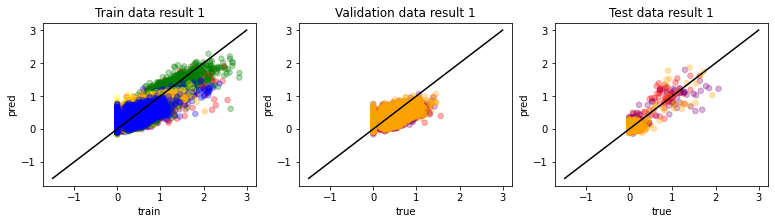

Epoch  24100 Train_loss:  0.16698642  Validation_loss:  0.17250398  Test_loss:  0.17732206
Epoch  24200 Train_loss:  0.16683961  Validation_loss:  0.17237167  Test_loss:  0.1773645
Epoch  24300 Train_loss:  0.16669334  Validation_loss:  0.17223717  Test_loss:  0.17741546
Epoch  24400 Train_loss:  0.16654804  Validation_loss:  0.17210004  Test_loss:  0.17743169
Epoch  24500 Train_loss:  0.16640015  Validation_loss:  0.1719704  Test_loss:  0.17749882
Epoch  24600 Train_loss:  0.16625579  Validation_loss:  0.17183146  Test_loss:  0.17750855
Epoch  24700 Train_loss:  0.16610819  Validation_loss:  0.17169812  Test_loss:  0.17757311
Epoch  24800 Train_loss:  0.16596043  Validation_loss:  0.17156823  Test_loss:  0.1776439
Epoch  24900 Train_loss:  0.16581425  Validation_loss:  0.17142819  Test_loss:  0.17766881
Epoch  25000 Train_loss:  0.16566633  Validation_loss:  0.1712932  Test_loss:  0.17771824


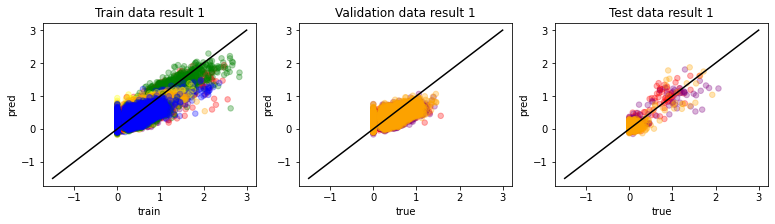

Epoch  25100 Train_loss:  0.16551891  Validation_loss:  0.17116334  Test_loss:  0.17779183
Epoch  25200 Train_loss:  0.16537158  Validation_loss:  0.17102702  Test_loss:  0.17783253
Epoch  25300 Train_loss:  0.1652246  Validation_loss:  0.17089298  Test_loss:  0.17789643
Epoch  25400 Train_loss:  0.16507918  Validation_loss:  0.1707513  Test_loss:  0.17789373
Epoch  25500 Train_loss:  0.16493069  Validation_loss:  0.17061986  Test_loss:  0.17795669
Epoch  25600 Train_loss:  0.16478388  Validation_loss:  0.1704826  Test_loss:  0.17801107
Epoch  25700 Train_loss:  0.16463475  Validation_loss:  0.1703548  Test_loss:  0.17810376
Epoch  25800 Train_loss:  0.16448888  Validation_loss:  0.17021169  Test_loss:  0.17808063
Epoch  25900 Train_loss:  0.16434096  Validation_loss:  0.17007658  Test_loss:  0.17814709
Epoch  26000 Train_loss:  0.16419287  Validation_loss:  0.16993977  Test_loss:  0.17818618


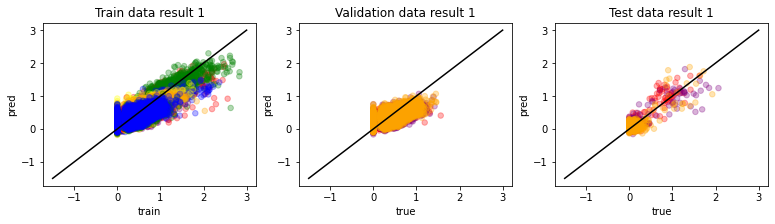

Epoch  26100 Train_loss:  0.16404544  Validation_loss:  0.16980323  Test_loss:  0.1782437
Epoch  26200 Train_loss:  0.16389662  Validation_loss:  0.16966625  Test_loss:  0.1782877
Epoch  26300 Train_loss:  0.16374896  Validation_loss:  0.16953437  Test_loss:  0.1783459
Epoch  26400 Train_loss:  0.16360117  Validation_loss:  0.16939162  Test_loss:  0.17837097
Epoch  26500 Train_loss:  0.16345201  Validation_loss:  0.16925763  Test_loss:  0.17845441
Epoch  26600 Train_loss:  0.163304  Validation_loss:  0.16911992  Test_loss:  0.17849642
Epoch  26700 Train_loss:  0.1631555  Validation_loss:  0.16898224  Test_loss:  0.17852888
Epoch  26800 Train_loss:  0.16300666  Validation_loss:  0.16884592  Test_loss:  0.17860028
Epoch  26900 Train_loss:  0.16285807  Validation_loss:  0.16871142  Test_loss:  0.17865464
Epoch  27000 Train_loss:  0.16271044  Validation_loss:  0.16857108  Test_loss:  0.17867388


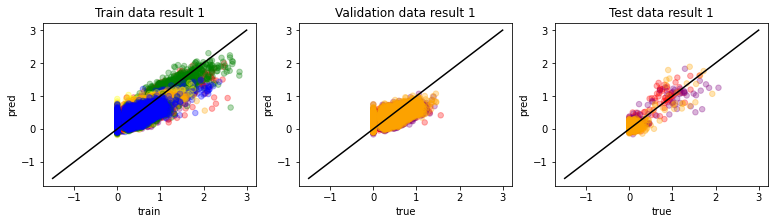

Epoch  27100 Train_loss:  0.16256033  Validation_loss:  0.16843383  Test_loss:  0.17875364
Epoch  27200 Train_loss:  0.16241318  Validation_loss:  0.16829516  Test_loss:  0.17878085
Epoch  27300 Train_loss:  0.16226454  Validation_loss:  0.16816309  Test_loss:  0.17887565
Epoch  27400 Train_loss:  0.16211517  Validation_loss:  0.1680187  Test_loss:  0.17890678
Epoch  27500 Train_loss:  0.16196606  Validation_loss:  0.16788025  Test_loss:  0.17894772
Epoch  27600 Train_loss:  0.16181836  Validation_loss:  0.16773964  Test_loss:  0.17897932
Epoch  27700 Train_loss:  0.16166846  Validation_loss:  0.16760387  Test_loss:  0.17903168
Epoch  27800 Train_loss:  0.16151857  Validation_loss:  0.16746394  Test_loss:  0.17908804
Epoch  27900 Train_loss:  0.16136931  Validation_loss:  0.1673285  Test_loss:  0.17916796
Epoch  28000 Train_loss:  0.16121908  Validation_loss:  0.16718729  Test_loss:  0.17920645


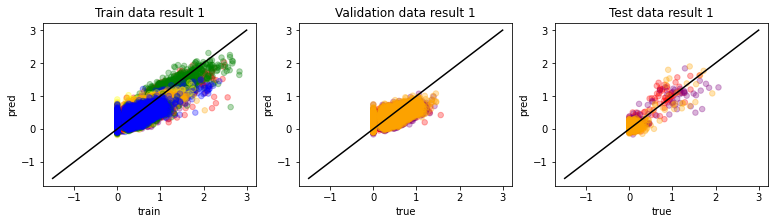

Epoch  28100 Train_loss:  0.16106975  Validation_loss:  0.16705123  Test_loss:  0.17928536
Epoch  28200 Train_loss:  0.1609204  Validation_loss:  0.1669092  Test_loss:  0.17931192
Epoch  28300 Train_loss:  0.16077003  Validation_loss:  0.16676871  Test_loss:  0.17936589
Epoch  28400 Train_loss:  0.16062059  Validation_loss:  0.16663057  Test_loss:  0.17942171
Epoch  28500 Train_loss:  0.16047125  Validation_loss:  0.16648829  Test_loss:  0.17946506
Epoch  28600 Train_loss:  0.16031994  Validation_loss:  0.16635351  Test_loss:  0.17955954
Epoch  28700 Train_loss:  0.16017002  Validation_loss:  0.16620845  Test_loss:  0.17959855
Epoch  28800 Train_loss:  0.16001946  Validation_loss:  0.16607139  Test_loss:  0.1796678
Epoch  28900 Train_loss:  0.15987043  Validation_loss:  0.16592526  Test_loss:  0.17969838
Epoch  29000 Train_loss:  0.1597185  Validation_loss:  0.16578937  Test_loss:  0.17979167


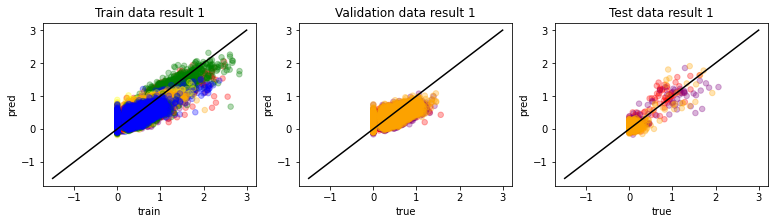

Epoch  29100 Train_loss:  0.15956913  Validation_loss:  0.16564523  Test_loss:  0.17982627
Epoch  29200 Train_loss:  0.15941821  Validation_loss:  0.16550848  Test_loss:  0.17991288
Epoch  29300 Train_loss:  0.1592683  Validation_loss:  0.16536386  Test_loss:  0.17994866
Epoch  29400 Train_loss:  0.1591173  Validation_loss:  0.16522259  Test_loss:  0.1800036
Epoch  29500 Train_loss:  0.15896669  Validation_loss:  0.16508311  Test_loss:  0.18006155
Epoch  29600 Train_loss:  0.15881643  Validation_loss:  0.16493785  Test_loss:  0.18008673
Epoch  29700 Train_loss:  0.15866601  Validation_loss:  0.16479799  Test_loss:  0.18013373
Epoch  29800 Train_loss:  0.15851359  Validation_loss:  0.16466132  Test_loss:  0.18023752
Epoch  29900 Train_loss:  0.15836252  Validation_loss:  0.16451721  Test_loss:  0.18028548
Epoch  30000 Train_loss:  0.15821162  Validation_loss:  0.16437261  Test_loss:  0.18034244


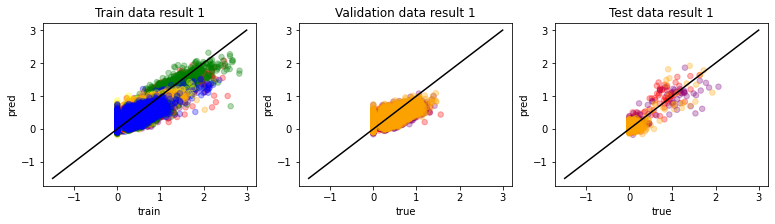

Epoch  30100 Train_loss:  0.15806094  Validation_loss:  0.1642294  Test_loss:  0.18038271
Epoch  30200 Train_loss:  0.15790819  Validation_loss:  0.16408943  Test_loss:  0.18045314
Epoch  30300 Train_loss:  0.15775904  Validation_loss:  0.16394717  Test_loss:  0.18048033
Epoch  30400 Train_loss:  0.15760648  Validation_loss:  0.16380474  Test_loss:  0.18054962
Epoch  30500 Train_loss:  0.15745325  Validation_loss:  0.16366155  Test_loss:  0.18063241
Epoch  30600 Train_loss:  0.15730363  Validation_loss:  0.16351475  Test_loss:  0.18064791
Epoch  30700 Train_loss:  0.15714882  Validation_loss:  0.16337617  Test_loss:  0.18074791
Epoch  30800 Train_loss:  0.15699764  Validation_loss:  0.16323143  Test_loss:  0.18078882
Epoch  30900 Train_loss:  0.15684469  Validation_loss:  0.16309242  Test_loss:  0.18089725
Epoch  31000 Train_loss:  0.1566931  Validation_loss:  0.16294473  Test_loss:  0.18091477


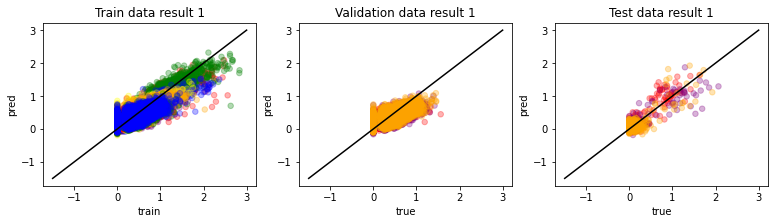

Epoch  31100 Train_loss:  0.15654095  Validation_loss:  0.16280253  Test_loss:  0.18098803
Epoch  31200 Train_loss:  0.1563886  Validation_loss:  0.16265583  Test_loss:  0.18104327
Epoch  31300 Train_loss:  0.15623672  Validation_loss:  0.16251071  Test_loss:  0.18109506
Epoch  31400 Train_loss:  0.15608406  Validation_loss:  0.16237216  Test_loss:  0.18119541
Epoch  31500 Train_loss:  0.15593107  Validation_loss:  0.16222447  Test_loss:  0.18125275
Epoch  31600 Train_loss:  0.15577888  Validation_loss:  0.16208285  Test_loss:  0.18131782
Epoch  31700 Train_loss:  0.15562515  Validation_loss:  0.16193335  Test_loss:  0.18134157
Epoch  31800 Train_loss:  0.15547264  Validation_loss:  0.16178887  Test_loss:  0.18139918
Epoch  31900 Train_loss:  0.15531994  Validation_loss:  0.16164467  Test_loss:  0.18144797
Epoch  32000 Train_loss:  0.15516686  Validation_loss:  0.1615007  Test_loss:  0.18152453


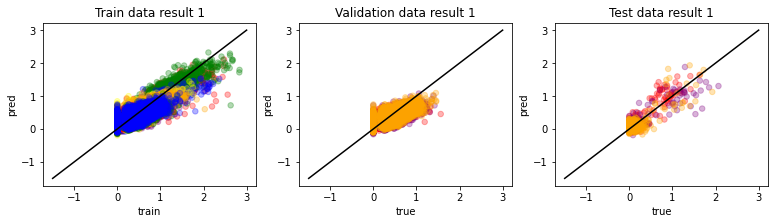

Epoch  32100 Train_loss:  0.1550137  Validation_loss:  0.16135365  Test_loss:  0.18157
Epoch  32200 Train_loss:  0.15486027  Validation_loss:  0.16120984  Test_loss:  0.18165678
Epoch  32300 Train_loss:  0.15470701  Validation_loss:  0.16106047  Test_loss:  0.1816746
Epoch  32400 Train_loss:  0.1545524  Validation_loss:  0.1609207  Test_loss:  0.18178037
Epoch  32500 Train_loss:  0.15440144  Validation_loss:  0.16076872  Test_loss:  0.18179753
Epoch  32600 Train_loss:  0.15424539  Validation_loss:  0.16062452  Test_loss:  0.18190217
Epoch  32700 Train_loss:  0.154093  Validation_loss:  0.16047639  Test_loss:  0.18195155
Epoch  32800 Train_loss:  0.15393846  Validation_loss:  0.16033246  Test_loss:  0.18203253
Epoch  32900 Train_loss:  0.15378456  Validation_loss:  0.16018823  Test_loss:  0.18208341
Epoch  33000 Train_loss:  0.15363131  Validation_loss:  0.16003703  Test_loss:  0.18212022


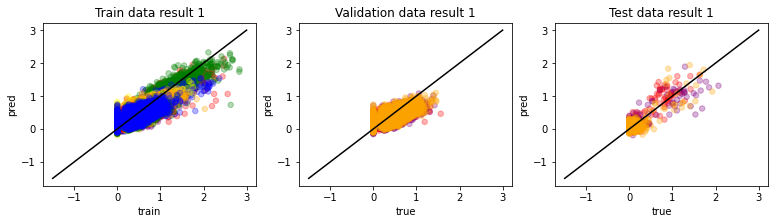

Epoch  33100 Train_loss:  0.15347937  Validation_loss:  0.15988983  Test_loss:  0.18215822
Epoch  33200 Train_loss:  0.15332295  Validation_loss:  0.15974714  Test_loss:  0.18225756
Epoch  33300 Train_loss:  0.15316977  Validation_loss:  0.15959878  Test_loss:  0.18231629
Epoch  33400 Train_loss:  0.15301457  Validation_loss:  0.15945087  Test_loss:  0.18237545
Epoch  33500 Train_loss:  0.15286078  Validation_loss:  0.15930389  Test_loss:  0.18242949
Epoch  33600 Train_loss:  0.1527056  Validation_loss:  0.15915608  Test_loss:  0.1824917
Epoch  33700 Train_loss:  0.15255173  Validation_loss:  0.15900831  Test_loss:  0.18254644
Epoch  33800 Train_loss:  0.15239915  Validation_loss:  0.1588601  Test_loss:  0.18258749
Epoch  33900 Train_loss:  0.15224175  Validation_loss:  0.15871209  Test_loss:  0.18268526
Epoch  34000 Train_loss:  0.15208884  Validation_loss:  0.15856205  Test_loss:  0.1827357


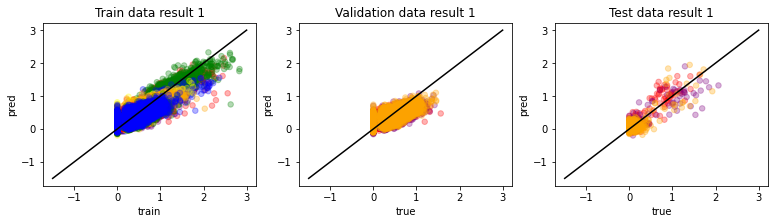

Epoch  34100 Train_loss:  0.15193239  Validation_loss:  0.1584162  Test_loss:  0.18281674
Epoch  34200 Train_loss:  0.15177876  Validation_loss:  0.15826702  Test_loss:  0.18284725
Epoch  34300 Train_loss:  0.15162304  Validation_loss:  0.15812114  Test_loss:  0.1829221
Epoch  34400 Train_loss:  0.15146776  Validation_loss:  0.15797132  Test_loss:  0.18298666
Epoch  34500 Train_loss:  0.15131187  Validation_loss:  0.15782484  Test_loss:  0.18306178
Epoch  34600 Train_loss:  0.15115888  Validation_loss:  0.15767238  Test_loss:  0.1830983
Epoch  34700 Train_loss:  0.15100262  Validation_loss:  0.15752247  Test_loss:  0.183174
Epoch  34800 Train_loss:  0.15084559  Validation_loss:  0.15737535  Test_loss:  0.18325946
Epoch  34900 Train_loss:  0.1506907  Validation_loss:  0.15722607  Test_loss:  0.18330523
Epoch  35000 Train_loss:  0.15053691  Validation_loss:  0.15707305  Test_loss:  0.18335064


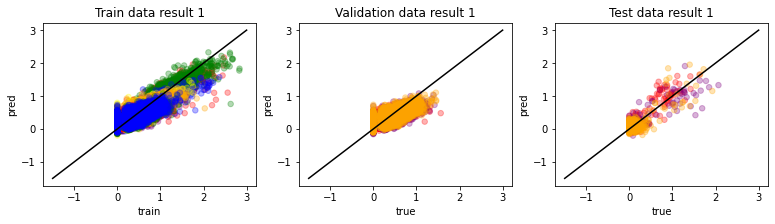

Epoch  35100 Train_loss:  0.15037994  Validation_loss:  0.15692456  Test_loss:  0.18343659
Epoch  35200 Train_loss:  0.15022317  Validation_loss:  0.15677881  Test_loss:  0.18353349
Epoch  35300 Train_loss:  0.1500695  Validation_loss:  0.15662555  Test_loss:  0.18355443
Epoch  35400 Train_loss:  0.1499126  Validation_loss:  0.15647571  Test_loss:  0.18362126
Epoch  35500 Train_loss:  0.14975722  Validation_loss:  0.15632369  Test_loss:  0.18367288
Epoch  35600 Train_loss:  0.14960223  Validation_loss:  0.1561721  Test_loss:  0.1837074
Epoch  35700 Train_loss:  0.14944425  Validation_loss:  0.15602462  Test_loss:  0.1838056
Epoch  35800 Train_loss:  0.14928766  Validation_loss:  0.15587649  Test_loss:  0.18387349
Epoch  35900 Train_loss:  0.14913158  Validation_loss:  0.1557238  Test_loss:  0.18394884
Epoch  36000 Train_loss:  0.14897467  Validation_loss:  0.1555751  Test_loss:  0.18401735


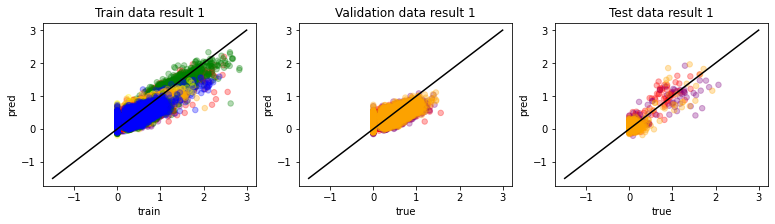

Epoch  36100 Train_loss:  0.14881736  Validation_loss:  0.1554226  Test_loss:  0.18407722
Epoch  36200 Train_loss:  0.14866044  Validation_loss:  0.15527226  Test_loss:  0.1841572
Epoch  36300 Train_loss:  0.14850473  Validation_loss:  0.15511951  Test_loss:  0.18418908
Epoch  36400 Train_loss:  0.14834946  Validation_loss:  0.15496758  Test_loss:  0.1842554
Epoch  36500 Train_loss:  0.14819211  Validation_loss:  0.15481591  Test_loss:  0.1843102
Epoch  36600 Train_loss:  0.14803421  Validation_loss:  0.15466459  Test_loss:  0.18438111
Epoch  36700 Train_loss:  0.14787726  Validation_loss:  0.1545155  Test_loss:  0.1844566
Epoch  36800 Train_loss:  0.14772013  Validation_loss:  0.15436386  Test_loss:  0.1845249
Epoch  36900 Train_loss:  0.1475626  Validation_loss:  0.15421122  Test_loss:  0.18459201
Epoch  37000 Train_loss:  0.14740588  Validation_loss:  0.15405758  Test_loss:  0.18465467


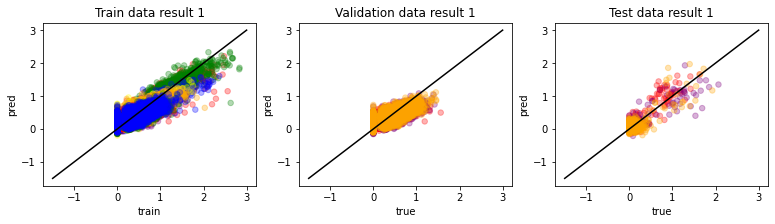

Epoch  37100 Train_loss:  0.14725003  Validation_loss:  0.15390505  Test_loss:  0.18469499
Epoch  37200 Train_loss:  0.14709316  Validation_loss:  0.15375172  Test_loss:  0.18477318
Epoch  37300 Train_loss:  0.1469337  Validation_loss:  0.1536004  Test_loss:  0.18485124
Epoch  37400 Train_loss:  0.14677866  Validation_loss:  0.15344591  Test_loss:  0.18487291
Epoch  37500 Train_loss:  0.1466192  Validation_loss:  0.15329692  Test_loss:  0.18497159
Epoch  37600 Train_loss:  0.14646126  Validation_loss:  0.15314291  Test_loss:  0.18503731
Epoch  37700 Train_loss:  0.14630465  Validation_loss:  0.15298787  Test_loss:  0.18508829
Epoch  37800 Train_loss:  0.14614637  Validation_loss:  0.15283474  Test_loss:  0.1851424
Epoch  37900 Train_loss:  0.1459881  Validation_loss:  0.15268132  Test_loss:  0.1852248
Epoch  38000 Train_loss:  0.14583011  Validation_loss:  0.15252739  Test_loss:  0.18528622


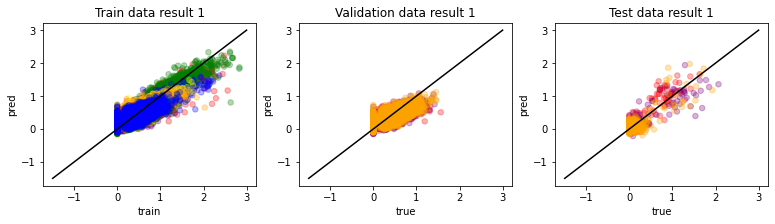

Epoch  38100 Train_loss:  0.14567286  Validation_loss:  0.15237604  Test_loss:  0.18535925
Epoch  38200 Train_loss:  0.14551552  Validation_loss:  0.1522245  Test_loss:  0.18543415
Epoch  38300 Train_loss:  0.14535727  Validation_loss:  0.15206695  Test_loss:  0.18548141
Epoch  38400 Train_loss:  0.145198  Validation_loss:  0.15191491  Test_loss:  0.18556662
Epoch  38500 Train_loss:  0.1450404  Validation_loss:  0.15176076  Test_loss:  0.18561815
Epoch  38600 Train_loss:  0.14488164  Validation_loss:  0.1516062  Test_loss:  0.18569292
Epoch  38700 Train_loss:  0.1447234  Validation_loss:  0.15145183  Test_loss:  0.18575417
Epoch  38800 Train_loss:  0.14456649  Validation_loss:  0.15129592  Test_loss:  0.18578798
Epoch  38900 Train_loss:  0.1444081  Validation_loss:  0.15113994  Test_loss:  0.18586466
Epoch  39000 Train_loss:  0.14424738  Validation_loss:  0.15098833  Test_loss:  0.18594874


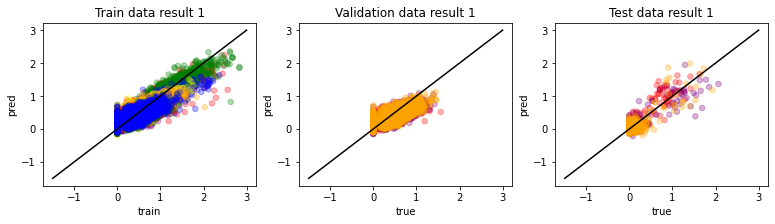

Epoch  39100 Train_loss:  0.14408943  Validation_loss:  0.15083925  Test_loss:  0.18603669
Epoch  39200 Train_loss:  0.14393322  Validation_loss:  0.15067881  Test_loss:  0.18604271
Epoch  39300 Train_loss:  0.14377096  Validation_loss:  0.15052554  Test_loss:  0.18614888
Epoch  39400 Train_loss:  0.14361365  Validation_loss:  0.15036885  Test_loss:  0.18617743
Epoch  39500 Train_loss:  0.14345473  Validation_loss:  0.15021445  Test_loss:  0.1862458
Epoch  39600 Train_loss:  0.14329575  Validation_loss:  0.15005797  Test_loss:  0.18631712
Epoch  39700 Train_loss:  0.14313664  Validation_loss:  0.14990368  Test_loss:  0.1864068
Epoch  39800 Train_loss:  0.14297625  Validation_loss:  0.14974646  Test_loss:  0.18646927
Epoch  39900 Train_loss:  0.14281988  Validation_loss:  0.14958952  Test_loss:  0.186505
Epoch  40000 Train_loss:  0.14265844  Validation_loss:  0.14943765  Test_loss:  0.1866071


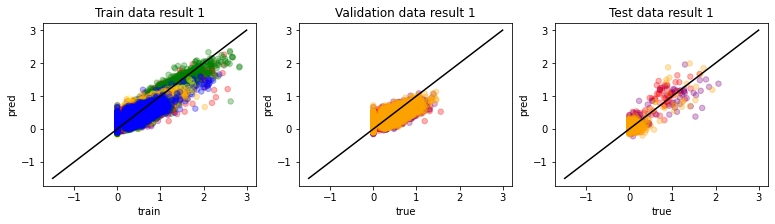

Epoch  40100 Train_loss:  0.14249943  Validation_loss:  0.14928028  Test_loss:  0.186638
Epoch  40200 Train_loss:  0.14233896  Validation_loss:  0.14912425  Test_loss:  0.18672916
Epoch  40300 Train_loss:  0.14218235  Validation_loss:  0.14896877  Test_loss:  0.18676047
Epoch  40400 Train_loss:  0.14202134  Validation_loss:  0.14881158  Test_loss:  0.18684013
Epoch  40500 Train_loss:  0.14186187  Validation_loss:  0.148655  Test_loss:  0.18688276
Epoch  40600 Train_loss:  0.14170139  Validation_loss:  0.1484983  Test_loss:  0.18697762
Epoch  40700 Train_loss:  0.14154245  Validation_loss:  0.14834091  Test_loss:  0.18703125
Epoch  40800 Train_loss:  0.14138144  Validation_loss:  0.14818776  Test_loss:  0.18712379
Epoch  40900 Train_loss:  0.14122221  Validation_loss:  0.14802909  Test_loss:  0.18715979
Epoch  41000 Train_loss:  0.14106144  Validation_loss:  0.1478741  Test_loss:  0.18727696


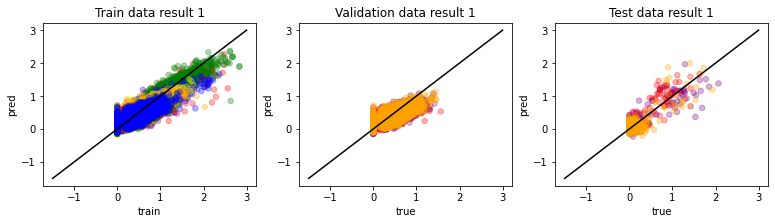

Epoch  41100 Train_loss:  0.14090309  Validation_loss:  0.14771478  Test_loss:  0.18730994
Epoch  41200 Train_loss:  0.14074336  Validation_loss:  0.14755553  Test_loss:  0.18735921
Epoch  41300 Train_loss:  0.14058417  Validation_loss:  0.14739786  Test_loss:  0.18740137
Epoch  41400 Train_loss:  0.14042173  Validation_loss:  0.14724572  Test_loss:  0.18751377
Epoch  41500 Train_loss:  0.14026271  Validation_loss:  0.14708757  Test_loss:  0.18755881
Epoch  41600 Train_loss:  0.1401028  Validation_loss:  0.14692624  Test_loss:  0.18760182
Epoch  41700 Train_loss:  0.13994333  Validation_loss:  0.14676847  Test_loss:  0.18764386
Epoch  41800 Train_loss:  0.13978143  Validation_loss:  0.14660941  Test_loss:  0.18771
Epoch  41900 Train_loss:  0.13962118  Validation_loss:  0.14645734  Test_loss:  0.18781328
Epoch  42000 Train_loss:  0.13946149  Validation_loss:  0.14629576  Test_loss:  0.18784142


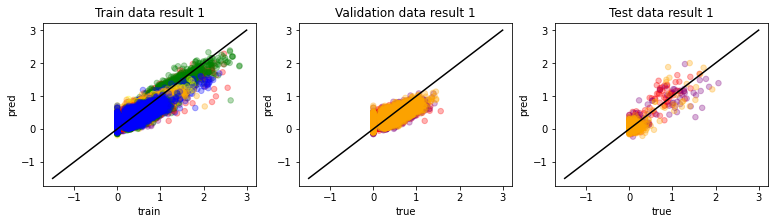

Epoch  42100 Train_loss:  0.13930057  Validation_loss:  0.14613716  Test_loss:  0.18789673
Epoch  42200 Train_loss:  0.1391406  Validation_loss:  0.14598009  Test_loss:  0.18798925
Epoch  42300 Train_loss:  0.1389789  Validation_loss:  0.14582203  Test_loss:  0.18805617
Epoch  42400 Train_loss:  0.13881847  Validation_loss:  0.14566357  Test_loss:  0.1881156
Epoch  42500 Train_loss:  0.13865934  Validation_loss:  0.14550312  Test_loss:  0.18815842
Epoch  42600 Train_loss:  0.1384969  Validation_loss:  0.14534862  Test_loss:  0.18825471
Epoch  42700 Train_loss:  0.13833705  Validation_loss:  0.14518766  Test_loss:  0.18827792
Epoch  42800 Train_loss:  0.13817737  Validation_loss:  0.14502944  Test_loss:  0.18832645
Epoch  42900 Train_loss:  0.13801622  Validation_loss:  0.14486945  Test_loss:  0.18840514
Epoch  43000 Train_loss:  0.13785663  Validation_loss:  0.14470968  Test_loss:  0.18846172


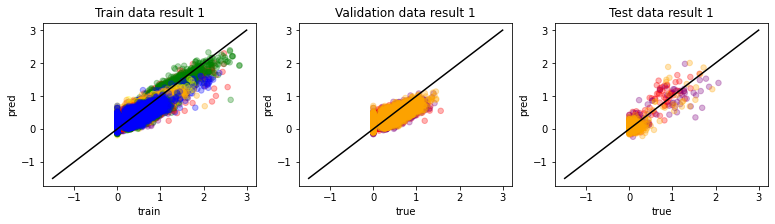

Epoch  43100 Train_loss:  0.13769388  Validation_loss:  0.14455235  Test_loss:  0.18852647
Epoch  43200 Train_loss:  0.13753244  Validation_loss:  0.144394  Test_loss:  0.1886024
Epoch  43300 Train_loss:  0.1373724  Validation_loss:  0.14423606  Test_loss:  0.18866035
Epoch  43400 Train_loss:  0.13721086  Validation_loss:  0.14407663  Test_loss:  0.18872876
Epoch  43500 Train_loss:  0.13705  Validation_loss:  0.14391598  Test_loss:  0.18877688
Epoch  43600 Train_loss:  0.1368891  Validation_loss:  0.14375418  Test_loss:  0.18882662
Epoch  43700 Train_loss:  0.13672748  Validation_loss:  0.14359647  Test_loss:  0.18890235
Epoch  43800 Train_loss:  0.13656513  Validation_loss:  0.14343631  Test_loss:  0.18897918
Epoch  43900 Train_loss:  0.13640434  Validation_loss:  0.14327532  Test_loss:  0.18903793
Epoch  44000 Train_loss:  0.13624409  Validation_loss:  0.14311725  Test_loss:  0.18908533


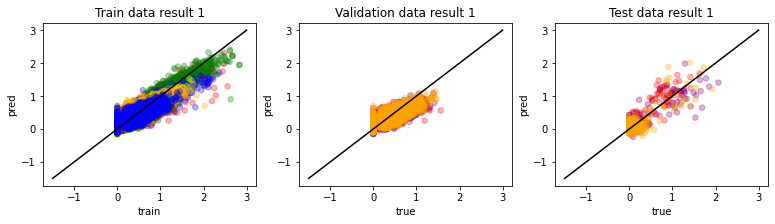

Epoch  44100 Train_loss:  0.13608241  Validation_loss:  0.14295933  Test_loss:  0.18916306
Epoch  44200 Train_loss:  0.13592128  Validation_loss:  0.14280093  Test_loss:  0.18922825
Epoch  44300 Train_loss:  0.1357609  Validation_loss:  0.14263721  Test_loss:  0.18926013
Epoch  44400 Train_loss:  0.13559975  Validation_loss:  0.14247854  Test_loss:  0.18933184
Epoch  44500 Train_loss:  0.13543735  Validation_loss:  0.14231971  Test_loss:  0.18941365
Epoch  44600 Train_loss:  0.13527484  Validation_loss:  0.1421588  Test_loss:  0.18947358
Epoch  44700 Train_loss:  0.13511369  Validation_loss:  0.14200032  Test_loss:  0.18956938
Epoch  44800 Train_loss:  0.13495211  Validation_loss:  0.14183405  Test_loss:  0.18958175
Epoch  44900 Train_loss:  0.1347896  Validation_loss:  0.14167745  Test_loss:  0.18968743
Epoch  45000 Train_loss:  0.1346315  Validation_loss:  0.14151381  Test_loss:  0.18968044


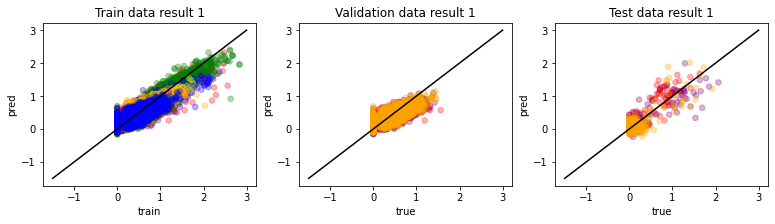

Epoch  45100 Train_loss:  0.13446763  Validation_loss:  0.14135525  Test_loss:  0.18977512
Epoch  45200 Train_loss:  0.1343052  Validation_loss:  0.14119634  Test_loss:  0.18985477
Epoch  45300 Train_loss:  0.13414347  Validation_loss:  0.14103305  Test_loss:  0.18988644
Epoch  45400 Train_loss:  0.13398352  Validation_loss:  0.14087142  Test_loss:  0.18993254
Epoch  45500 Train_loss:  0.13382213  Validation_loss:  0.14070837  Test_loss:  0.1899752
Epoch  45600 Train_loss:  0.13365903  Validation_loss:  0.14054929  Test_loss:  0.1900468
Epoch  45700 Train_loss:  0.13349673  Validation_loss:  0.1403881  Test_loss:  0.19013001
Epoch  45800 Train_loss:  0.13333496  Validation_loss:  0.14022641  Test_loss:  0.19018845
Epoch  45900 Train_loss:  0.13317233  Validation_loss:  0.14006732  Test_loss:  0.19026001
Epoch  46000 Train_loss:  0.13301066  Validation_loss:  0.13990608  Test_loss:  0.19033091


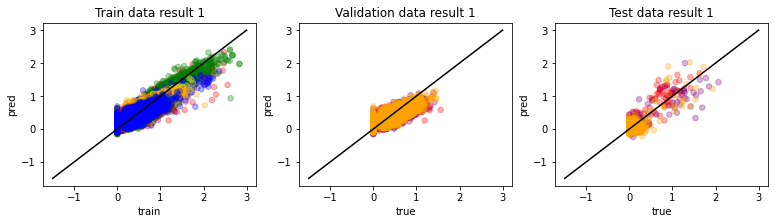

Epoch  46100 Train_loss:  0.13284993  Validation_loss:  0.13974354  Test_loss:  0.19035293
Epoch  46200 Train_loss:  0.13268766  Validation_loss:  0.13958265  Test_loss:  0.1904238
Epoch  46300 Train_loss:  0.13252597  Validation_loss:  0.1394202  Test_loss:  0.19049318
Epoch  46400 Train_loss:  0.13236286  Validation_loss:  0.13925925  Test_loss:  0.19055633
Epoch  46500 Train_loss:  0.13220215  Validation_loss:  0.13909781  Test_loss:  0.19060193
Epoch  46600 Train_loss:  0.13203865  Validation_loss:  0.13893662  Test_loss:  0.19066422
Epoch  46700 Train_loss:  0.13187835  Validation_loss:  0.1387726  Test_loss:  0.19070163
Epoch  46800 Train_loss:  0.13171531  Validation_loss:  0.13861297  Test_loss:  0.19078155
Epoch  46900 Train_loss:  0.13155174  Validation_loss:  0.13845004  Test_loss:  0.19086519
Epoch  47000 Train_loss:  0.13138956  Validation_loss:  0.1382933  Test_loss:  0.19097115


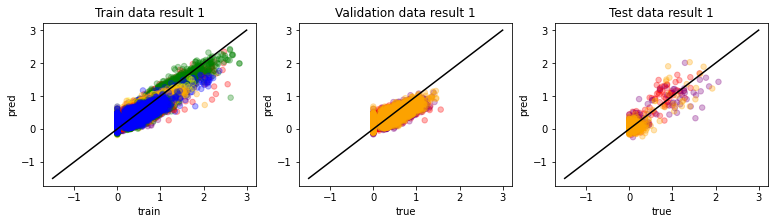

Epoch  47100 Train_loss:  0.13122958  Validation_loss:  0.13812569  Test_loss:  0.19095902
Epoch  47200 Train_loss:  0.13106558  Validation_loss:  0.13796675  Test_loss:  0.19104508
Epoch  47300 Train_loss:  0.13090381  Validation_loss:  0.13780297  Test_loss:  0.19109182
Epoch  47400 Train_loss:  0.13074286  Validation_loss:  0.13763967  Test_loss:  0.1911589
Epoch  47500 Train_loss:  0.13057862  Validation_loss:  0.13747948  Test_loss:  0.19122472
Epoch  47600 Train_loss:  0.13041662  Validation_loss:  0.13731754  Test_loss:  0.1912886
Epoch  47700 Train_loss:  0.13025434  Validation_loss:  0.13715464  Test_loss:  0.19134696
Epoch  47800 Train_loss:  0.13009417  Validation_loss:  0.13700041  Test_loss:  0.1914106
Epoch  47900 Train_loss:  0.12993172  Validation_loss:  0.13683136  Test_loss:  0.19145015
Epoch  48000 Train_loss:  0.12976916  Validation_loss:  0.13666844  Test_loss:  0.19148588


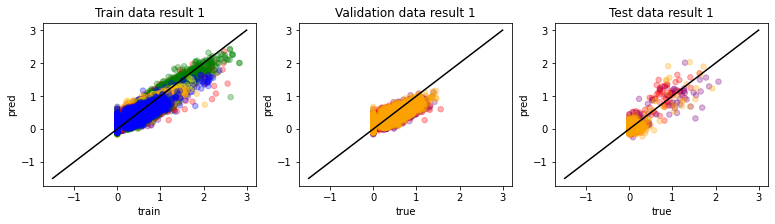

Epoch  48100 Train_loss:  0.12960446  Validation_loss:  0.13650419  Test_loss:  0.19156057
Epoch  48200 Train_loss:  0.1294427  Validation_loss:  0.13634188  Test_loss:  0.1916016
Epoch  48300 Train_loss:  0.12928116  Validation_loss:  0.13617875  Test_loss:  0.191674
Epoch  48400 Train_loss:  0.1291185  Validation_loss:  0.13601652  Test_loss:  0.19175716
Epoch  48500 Train_loss:  0.12895502  Validation_loss:  0.13585521  Test_loss:  0.19181073
Epoch  48600 Train_loss:  0.1287936  Validation_loss:  0.13569334  Test_loss:  0.1918772
Epoch  48700 Train_loss:  0.12863019  Validation_loss:  0.13553591  Test_loss:  0.191979
Epoch  48800 Train_loss:  0.12846775  Validation_loss:  0.13536525  Test_loss:  0.19198081
Epoch  48900 Train_loss:  0.12830634  Validation_loss:  0.13521028  Test_loss:  0.19208325
Epoch  49000 Train_loss:  0.12814605  Validation_loss:  0.13504025  Test_loss:  0.19209106


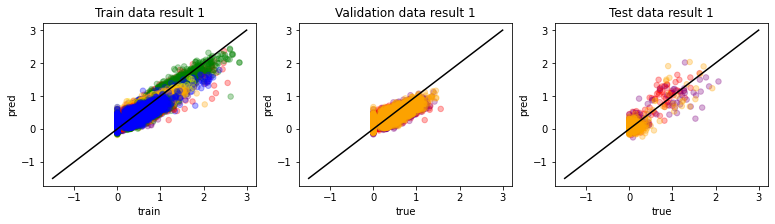

Epoch  49100 Train_loss:  0.12798001  Validation_loss:  0.1348796  Test_loss:  0.19218624
Epoch  49200 Train_loss:  0.12781852  Validation_loss:  0.13471475  Test_loss:  0.19221757
Epoch  49300 Train_loss:  0.12765591  Validation_loss:  0.13455635  Test_loss:  0.19231644
Epoch  49400 Train_loss:  0.12749398  Validation_loss:  0.13438633  Test_loss:  0.1923439
Epoch  49500 Train_loss:  0.12733135  Validation_loss:  0.13422488  Test_loss:  0.19240695
Epoch  49600 Train_loss:  0.12716854  Validation_loss:  0.13406357  Test_loss:  0.19247717
Epoch  49700 Train_loss:  0.1270073  Validation_loss:  0.133899  Test_loss:  0.19250084
Epoch  49800 Train_loss:  0.12684445  Validation_loss:  0.13373849  Test_loss:  0.19257839
Epoch  49900 Train_loss:  0.12668294  Validation_loss:  0.13357297  Test_loss:  0.1926138


In [40]:
num_epochs = 50000
learning_rate = 0.0001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)